In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import gym
from utils import *
from collections import namedtuple

import torch as tr
import gym

%load_ext autoreload
%autoreload 2

In [2]:
expertL = []
ns = 5
for i in range(ns):
  e = tr.load('experts/agent_%.2i-tasklen50-ne_5001-TD1'%i)
  expertL.append(e)
# expert1 = tr.load('experts/agent_01-tasklen50-ne_3000-TD1')
# expert2 = tr.load('experts/agent_02-tasklen50-ne_3000-TD1')
# novice0 = tr.load('experts/agent_00-tasklen50-ne_100-TD1')
# novice1 = tr.load('experts/agent_01-tasklen50-ne_100-TD1')
# novice2 = tr.load('experts/agent_02-tasklen50-ne_100-TD1')

# expertL = [expert0,expert1,expert2]

In [3]:
# evaluate experts
ntr=100
R = np.zeros([ns,ntr])
for ie,expert in enumerate(expertL):
  np.random.seed(ie)
  tr.manual_seed(ie)
  task = Task(task_name='CartPole-v1',max_ep_len=50)
  for t in range(ntr):
    traj = task.play_ep(pi=expert.act)
    expD = unpack_expL(traj)
    R[ie,t] = np.sum(expD['reward'])
print(ie,R.mean(1),R.std(1))

4 [50.   50.   49.69 10.58 11.06] [0.         0.         2.41534677 0.9917661  1.19849906]


In [4]:
# def calc_traj_is(X):
#   Y = -tr.ones([len(X)])
#   for t in range(len(X),0,-1):
#     Y[len(X)-t] = X[-t:].prod(0)
#   return Y

In [5]:
# actor = expert0
# learner = expert2

# traj = task.play_ep(pi=actor.act)
# expD = unpack_expL(traj)
# _vh,muact = actor.forward(expD['state'])
# mu_a_s = muact.softmax(-1)
# _vh,piact = learner.forward(expD['state'])
# pi_a_s = piact.softmax(-1)
# is_weight = tr.min(tr.tensor(1.09),(pi_a_s/mu_a_s))
# is_weight = tr.gather(is_weight,1,tr.Tensor(expD['action']).long().unsqueeze(1))



### IS weight between experts

In [6]:
import itertools
nitr = 100
MRho = np.zeros([ns,ns,nitr])
for idx,(actor,learner) in enumerate(itertools.product(expertL,expertL)):
  for itr in range(nitr):
    # sample
    traj = task.play_ep(pi=actor.act)
    expD = unpack_expL(traj)
    # fwprop on both policies
    _vh,muact = actor.forward(expD['state'])
    mu_a_s = muact.softmax(-1)
    _vh,piact = learner.forward(expD['state'])
    pi_a_s = piact.softmax(-1)
    # counts
    MRho.reshape(-1,nitr)[idx,itr] = tr.mean(pi_a_s/mu_a_s)

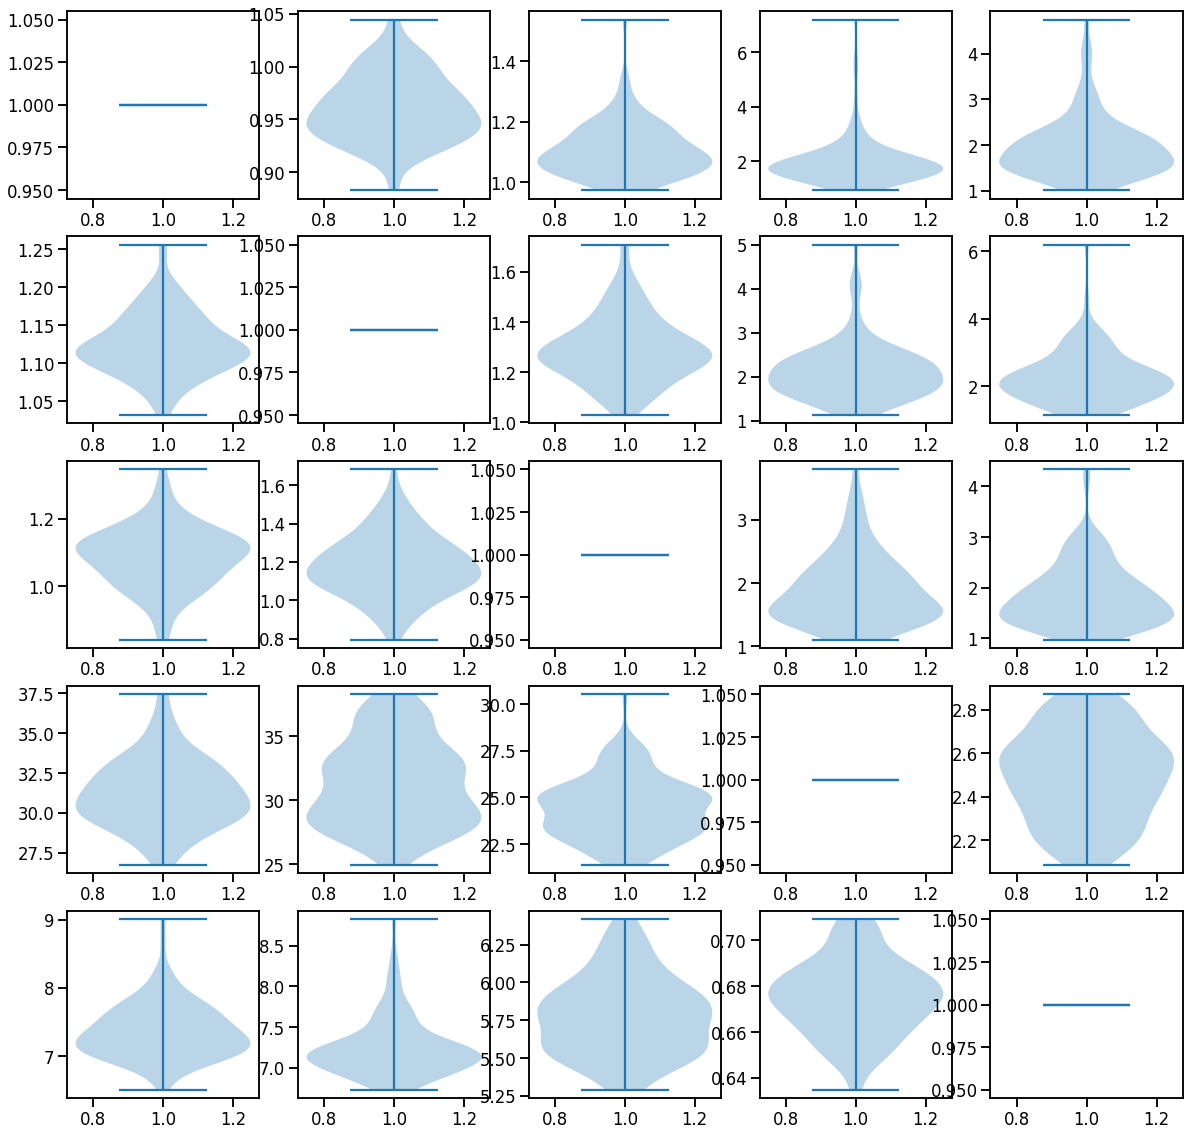

In [7]:
f,axar = plt.subplots(ns,ns,figsize=(20,20))
# plt.violinplot(MRho)
for i,j in itertools.product(range(ns),range(ns)):
  axar[i,j].violinplot(MRho[i,j])
#   axar[i,j].set_ylim(0,10)
plt.savefig('figures/violin-actor-learner-agreement')

In [8]:
# # is_weight
# nitr = 500
# actor = expert2
# # learner = novice2
# L = tr.zeros(nitr)
# for li,learner in enumerate([expert0,expert1,expert2,novice0,novice1,novice2]):
#   for i in range(nitr):
#     traj = task.play_ep(pi=actor.act)
#     expD = unpack_expL(traj)
#     _vh,muact = actor.forward(expD['state'])
#     mu_a_s = muact.softmax(-1)
#     _vh,piact = learner.forward(expD['state'])
#     pi_a_s = piact.softmax(-1)
#     L[i] = sum(piact.argmax(1)==muact.argmax(1))
#   plt.violinplot(L.detach().numpy(),positions=[li])
# # plt.set_xlabel('first three 2kexperts, last three novices')
# plt.savefig('figures/violin-actor-learner-agreement')